# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnaissance des objets de la base de test. 

Le notebook sera déposé sur la plateforme moodle du cours.

## Fichier par Mathis Roubille et Thomas Dupois 

In [41]:
import os
import zipfile
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


# Test GPU

Vérifie si un GPU est disponible pour l'entraînement et configure l'allocation de mémoire GPU.  
Configure TensorFlow pour allouer la mémoire GPU de manière dynamique, évitant les conflits avec d'autres processus ou applications.  
Utiliser le GPU à la place du processeur de l'ordinateur permet nottament d'accélérer le processus d'apprentissage d'un facteur non négligeable.

In [42]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU détecté : {gpus}")
else:
    print("Aucun GPU détecté. Vérifiez vos installations.")
    exit()

Num GPUs Available:  1
GPU détecté : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Chargement des données

Pour entraîner notre modèle, nous avons décidé de collecter davantage d’images des trois catégories champignons afin de disposer d’un jeu de données plus étendu. Nous conservons le jeu de données d’origine pour tester notre modèle et utilisons notre nouveau corpus de plus de 11k+ images pour l’entraînement.
D'autres parts, les images récoltées ont été triées et sélectionnées par nos soins dû aux multiples erreurs d'images n'ayant pas de rapport avec les champignons. 

In [43]:
def Data():
    base_dir = "mushrooms"
    test_dir = "test_mushrooms"
    
    train_dir = os.path.join(base_dir)
    test_dir = os.path.join(test_dir)
    
    train_classes = os.listdir(train_dir)
    test_classes = os.listdir(test_dir)

    
    print("Classes d'entraînement:", train_classes)
    print("Classes de test:", test_classes)
    

    if set(train_classes) != set(test_classes):
        print("Attention : Les classes dans les ensembles d'entraînement et de test ne correspondent pas !")
    

    train_data = []
    for label in train_classes:
        image_files = os.listdir(os.path.join(train_dir, label))
        train_data.extend([(label, os.path.join(train_dir, label, f)) for f in image_files])
    
    test_data = []
    for label in test_classes:
        image_files = os.listdir(os.path.join(test_dir, label))
        test_data.extend([(label, os.path.join(test_dir, label, f)) for f in image_files])
    

    print("Nombre total d'images d'entraînement:", len(train_data))
    print("Nombre total d'images de test:", len(test_data))
    print("Nombre d'images par classe dans l'ensemble d'entraînement:",
        {label: len(os.listdir(os.path.join(train_dir, label))) for label in train_classes if label != "test"})
    print("Nombre d'images par classe dans l'ensemble de test:",
        {label: len(os.listdir(os.path.join(test_dir, label))) for label in test_classes})
    
    return train_data, test_data

In [44]:
train_data, test_data = Data()

Classes d'entraînement: ['amanita', 'crimini', 'oyster']
Classes de test: ['amanita', 'crimini', 'oyster']
Nombre total d'images d'entraînement: 11742
Nombre total d'images de test: 1470
Nombre d'images par classe dans l'ensemble d'entraînement: {'amanita': 4179, 'crimini': 2914, 'oyster': 4649}
Nombre d'images par classe dans l'ensemble de test: {'amanita': 520, 'crimini': 416, 'oyster': 534}


## Exemple de données d'entraînement

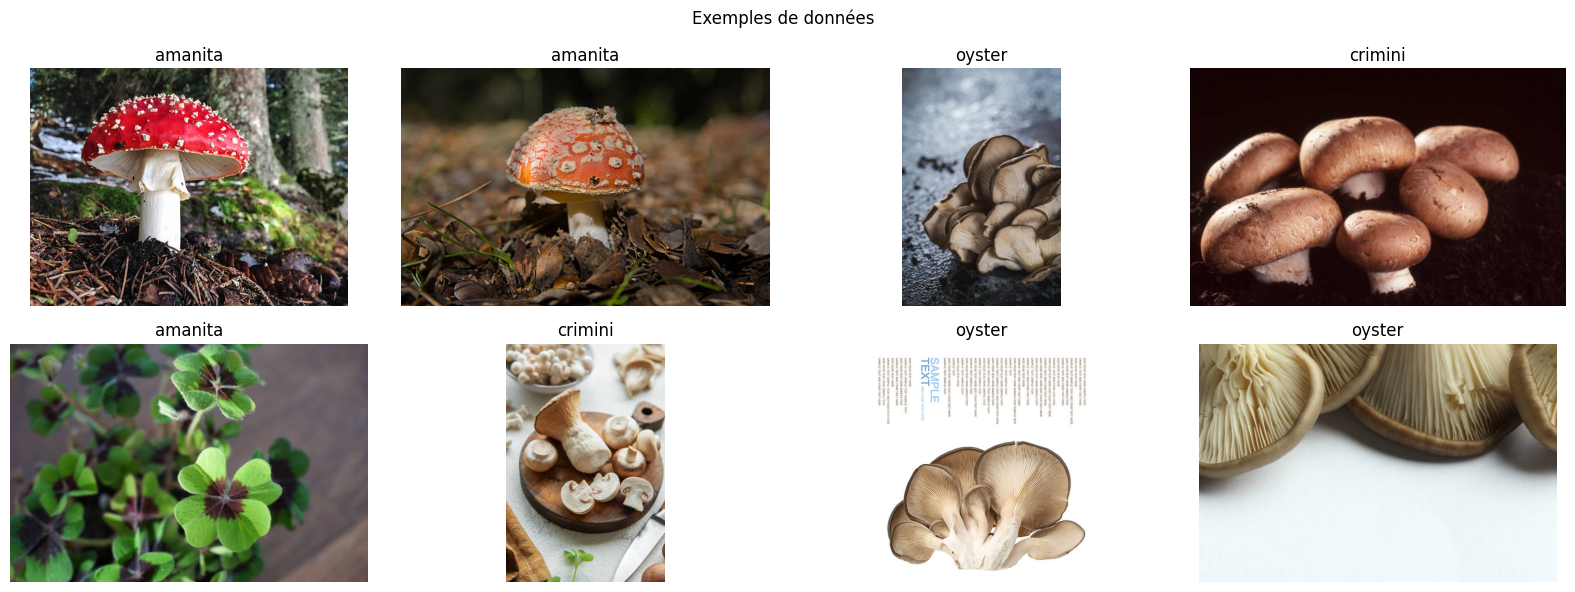

In [45]:
import matplotlib.pyplot as plt
image_samples = np.random.randint(0,high=len(train_data)-1, size=8)

fig = plt.figure(figsize=(16,6))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(2,4,i+1)
    axs.set_title(train_data[img_idx][0])
    image = Image.open(train_data[img_idx][1])
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Exemples de données")
plt.tight_layout()

## Generation de variation d'image

Applique des transformations pour augmenter la diversité des données d'entraînement (rotation, zoom, décalage, etc.) et normalise les images pour l'entraînement.
On utilise 224 pour la taille des images car il s'agit de la taille maximum utilisée par le modèle MobileNetV2.

In [46]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,                            # Normalisation des pixels (0-1)
    rotation_range=20,                          # Rotation aléatoire des images
    width_shift_range=0.2,                      # Décalage horizontal
    height_shift_range=0.2,                     # Décalage vertical
    shear_range=0.2,                            # Transformation en cisaillement
    zoom_range=0.2,                             # Zoom
    horizontal_flip=True,                       # Flip horizontal
    fill_mode='nearest'                         # Mode de remplissage
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)


train_dir = "mushrooms" 
test_dir  = "test_mushrooms"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,  
    class_mode='categorical'
)

Found 11742 images belonging to 3 classes.
Found 1470 images belonging to 3 classes.


## Ajustement des poids des classes en fonctions du nombres d'images

Le code suivant calcule des poids pour chaque classe en fonction de leur représentation dans le jeu de données. Ces poids sont utilisés pour équilibrer l'entraînement du modèle, en donnant plus d'importance aux classes sous-représentées (comme `crimini`). Cela aide le modèle à mieux généraliser, en évitant de privilégier les classes majoritaires.

In [47]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.9365877004067958, 1: 1.3431708991077556, 2: 0.8419014841901484}


## Callback

Définit un callback pour sauvegarder le modèle à intervalles réguliers.

In [48]:
from tensorflow.keras.callbacks import Callback

class SaveEveryNEpochs(Callback):
    def __init__(self, save_freq, model, save_path):
        super(SaveEveryNEpochs, self).__init__()
        self.save_freq = save_freq
        self.model_to_save = model
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            filepath = self.save_path.format(epoch=epoch + 1)
            self.model_to_save.save(filepath)
            print(f"Model saved at {filepath}")


## Charge le MobileNetV2-based Model ou charge un modèle déjà entrainé

## Choix du modèle

**GlobalAveragePooling2D** 

- Cette couche résume les caractéristiques spatiales de l'image extraites par MobileNetV2 en une seule valeur par canal.   
- Cela réduit la dimensionnalité tout en conservant des informations importantes.  
- Elle est moins sujette à un surapprentissage qu'un simple Flatten. 

**Dense(128, activation='relu') et Dense(64, activation='relu')**  

- Ces couches entièrement connectées servent à apprendre des représentations spécifiques à la tâche.  
- La fonction d'activation ReLU est utilisée pour introduire de la non-linéarité et améliorer la capacité d'apprentissage.  
- La réduction progressive des dimensions (de 128 à 64) agit comme une régularisation implicite. (Diminuer progressivement le nombre de neurones dans les couches denses aide le modèle à simplifier son apprentissage en évitant de mémoriser les détails inutiles ou spécifiques au jeu de données d'entraînement)

**Dropout(0.5)**  

- Cette technique désactive aléatoirement 50 % des neurones pendant l'entraînement pour réduire le surapprentissage 

**Dense(num_classes, activation='softmax')** 

- La dernière couche ajuste le modèle pour classer les images en num_classes.  
- L'activation Softmax est utilisée pour produire des probabilités pour chaque classe.  


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

EPOCHS = 100

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = train_generator.num_classes

try :
    print("Chargement du modèle existant...")
    model = load_model("mushroom_classifier_model.h5")
    print("Modèle chargé.")
except :
    print("Pas de modèle trouvé.\nCréation d'un nouveau modèle...")

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    for layer in base_model.layers[-20:]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

## Callbacks

In [ ]:
save_every_n_epochs = SaveEveryNEpochs(
    save_freq=1, 
    model=model, 
    save_path="model/model_epoch_{epoch:02d}.h5"
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

## Entraînement

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), #Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[save_every_n_epochs, early_stopping, checkpoint]
)

## Save

In [50]:
model.save('mushroom_classifier_model.h5')

/home/xerneas02/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load

In [51]:
model = load_model('best_model.h5')
input_shape = model.input_shape
_, img_height, img_width, _ = input_shape

## Test

Found 1470 images belonging to 3 classes.
 4/46 [=>............................] - ETA: 22s - loss: 0.0713 - accuracy: 0.9688

/home/xerneas02/.local/lib/python3.9/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


46/46 [==============================] - 26s 536ms/step - loss: 0.2756 - accuracy: 0.9313
Précision sur l'ensemble de test: 0.93


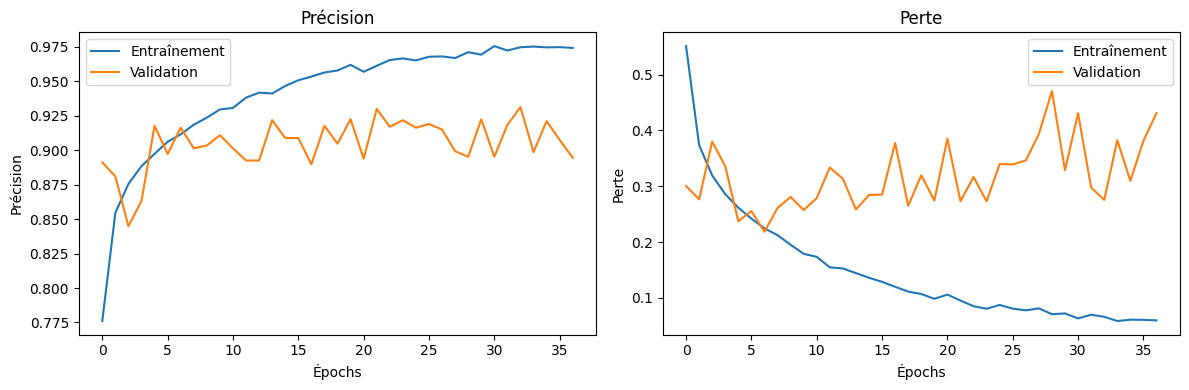

In [52]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Précision sur l'ensemble de test: {test_acc:.2f}")


plt.figure(figsize=(12, 4))

#Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

#Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

 4/46 [=>............................] - ETA: 17s

/home/xerneas02/.local/lib/python3.9/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


46/46 [==============================] - 20s 442ms/step
Correct : 1369
Incorrect : 101


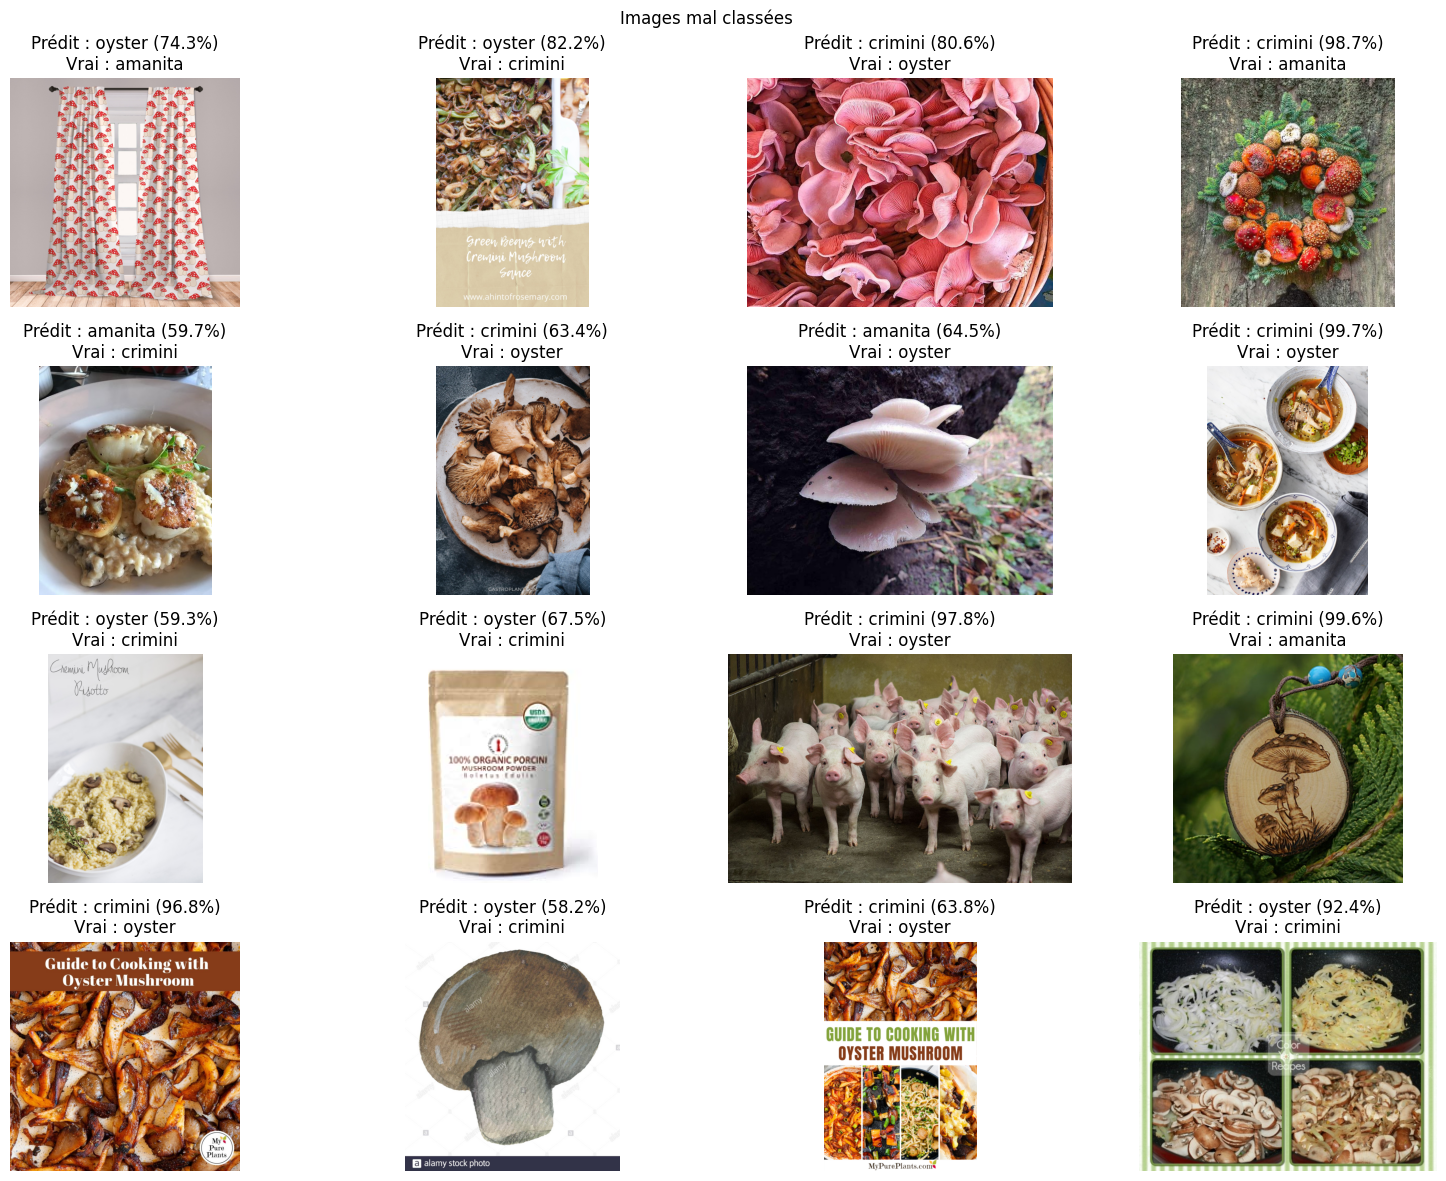

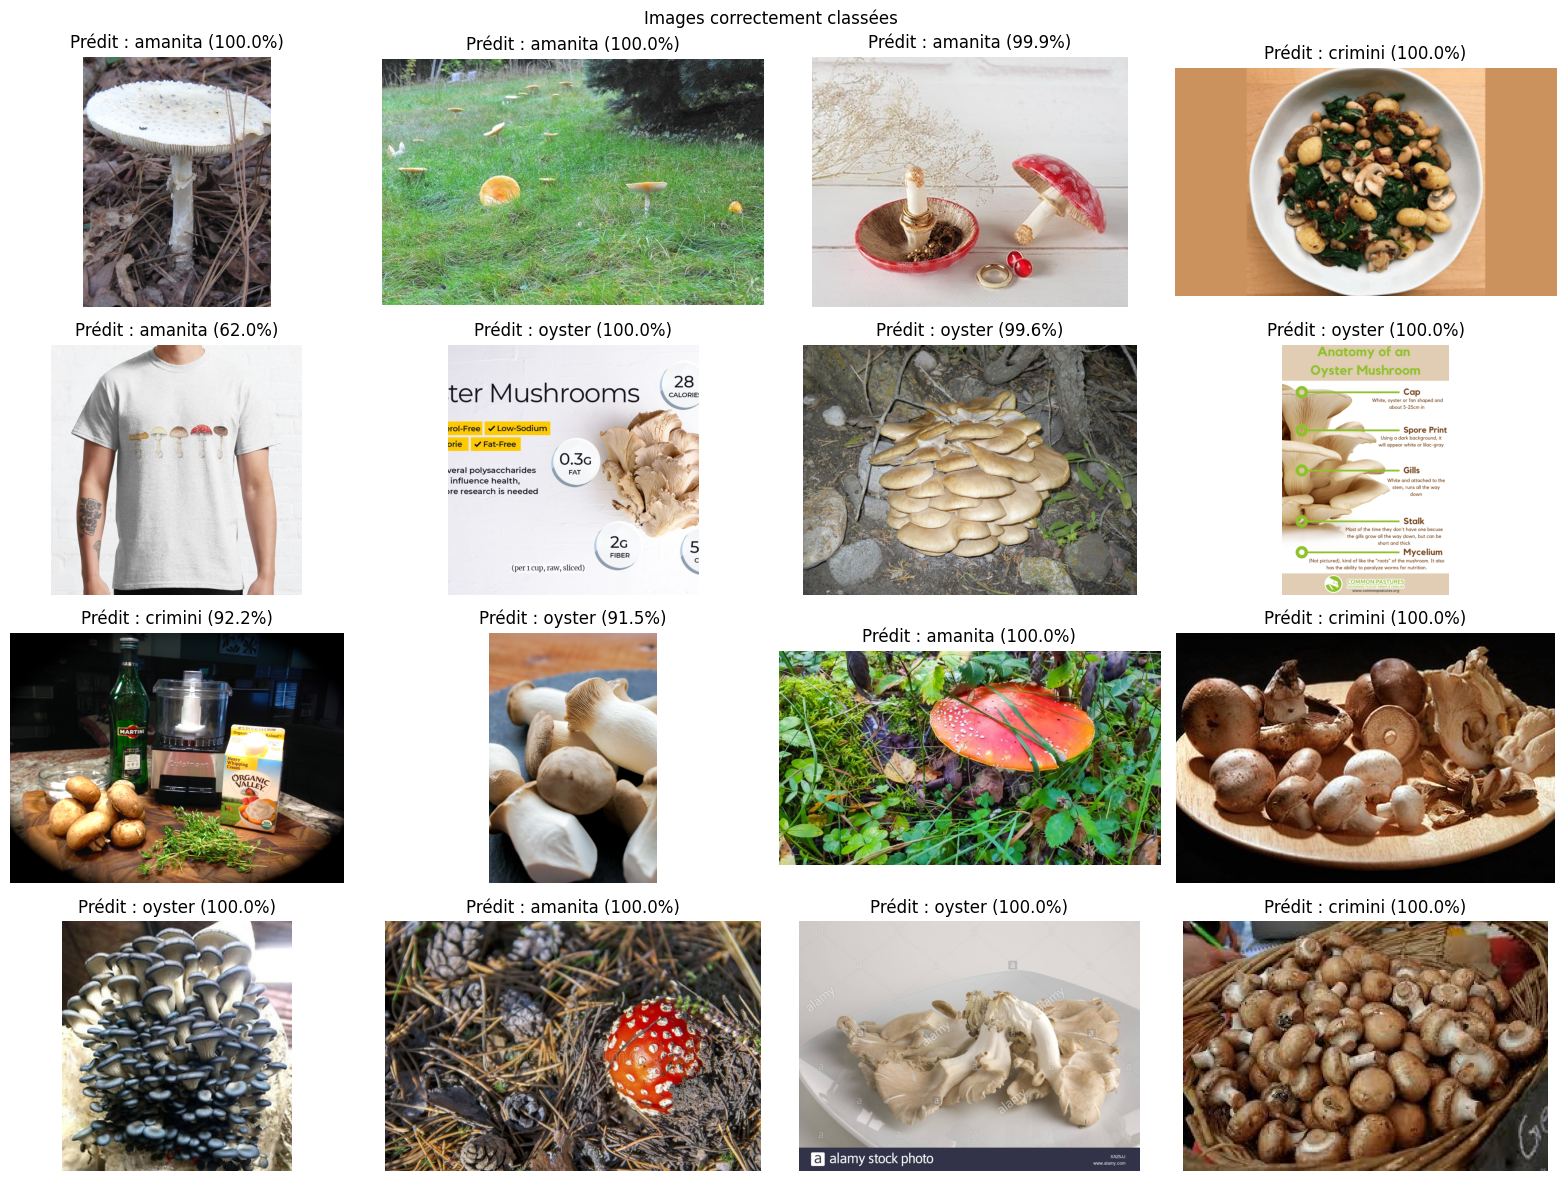

Taux de réussite global : 93.13%
Taux de réussite par catégorie :
  - amanita : 96.73%
  - crimini : 88.94%
  - oyster : 92.88%


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

Y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred_confidence = np.max(Y_pred, axis=1) 

y_true = test_generator.classes

correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

accuracy = len(correct) / len(y_true) * 100

category_accuracy = {}
for class_name in class_names:
    class_idx = class_indices[class_name]
    total_in_class = np.sum(y_true == class_idx)
    correct_in_class = np.sum((y_true == class_idx) & (y_pred == class_idx))
    if total_in_class > 0:
        category_accuracy[class_name] = correct_in_class / total_in_class * 100
    else:
        category_accuracy[class_name] = None


def display_images(indices, title):
    num_samples = 16
    if len(indices) < num_samples:
        num_samples = len(indices)
    image_samples = np.random.choice(indices, size=num_samples, replace=False)
    
    fig = plt.figure(figsize=(16, 12))
    for i, idx in enumerate(image_samples):
        axs = fig.add_subplot(4, 4, i+1)
        image_path = test_generator.filepaths[idx]
        image = Image.open(image_path)
        plt.imshow(image)
        
        confidence = y_pred_confidence[idx] * 100  # Convertir en pourcentage
        
        if title == "Images mal classées":
            axs.set_title(f"Prédit : {class_names[y_pred[idx]]} ({confidence:.1f}%)\nVrai : {class_names[y_true[idx]]}")
        else:
            axs.set_title(f"Prédit : {class_names[y_pred[idx]]} ({confidence:.1f}%)")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print(f"Correct : {len(correct)}")
print(f"Incorrect : {len(incorrect)}")


display_images(incorrect, "Images mal classées")
display_images(correct, "Images correctement classées")


print(f"Taux de réussite global : {accuracy:.2f}%")
print("Taux de réussite par catégorie :")
for class_name, acc in category_accuracy.items():
    if acc is not None:
        print(f"  - {class_name} : {acc:.2f}%")
    else:
        print(f"  - {class_name} : Pas d'images dans cette catégorie")


# Conclusion

Au cours de ce projet ayant comme objectif d'entraîner un modèle à catégoriser des champignons (crimini, oyster et amanita), nous avions tout d'abord essayer de partir de zéro en utilisant un réseau de neuronne comme ci-dessous:

| **Type de couche**              | **Détails**                                                                 |
|---------------------------------|-----------------------------------------------------------------------------|
| **Entrée**                      | Forme : `(IMG_HEIGHT, IMG_WIDTH, 3)` (images en couleur)                   |
| **Bloc de Convolution 1**       | `Conv2D(64, (3, 3), activation='relu', padding='same')`                    |
|                                 | `BatchNormalization()`                                                     |
|                                 | `MaxPooling2D(pool_size=(2, 2))`                                           |
| **Bloc de Convolution 2**       | `Conv2D(128, (3, 3), activation='relu', padding='same')`                   |
|                                 | `BatchNormalization()`                                                     |
|                                 | `MaxPooling2D(pool_size=(2, 2))`                                           |
| **Bloc de Convolution 3**       | `Conv2D(256, (3, 3), activation='relu', padding='same')`                   |
|                                 | `BatchNormalization()`                                                     |
|                                 | `MaxPooling2D(pool_size=(2, 2))`                                           |
| **Bloc de Convolution 4**       | `Conv2D(512, (3, 3), activation='relu', padding='same')`                   |
|                                 | `BatchNormalization()`                                                     |
|                                 | `MaxPooling2D(pool_size=(2, 2))`                                           |
| **Bloc de Convolution 5**       | `Conv2D(512, (3, 3), activation='relu', padding='same')`                   |
|                                 | `BatchNormalization()`                                                     |
|                                 | `MaxPooling2D(pool_size=(2, 2))`                                           |
| **Global Average Pooling**      | `GlobalAveragePooling2D()`                                                 |
| **Fully Connected Layer 1**     | `Dense(256, activation='relu')`                                            |
|                                 | `Dropout(0.5)`                                                             |
| **Fully Connected Layer 2**     | `Dense(128, activation='relu')`                                            |
|                                 | `Dropout(0.5)`                                                             |
| **Couche de sortie**            | `Dense(num_classes, activation='softmax')`                                 |
| **Optimiseur**                  | `adam`                                                                     |
| **Fonction de perte**           | `categorical_crossentropy`                                                 |
| **Métrique d'évaluation**       | `accuracy`                                                                 |


Cependant, après de multiples heures d'entrainement, le taux de réussite de reconnaissance des champignons pour notre échantillon de test convergeait vers **85%**.
Nous avons donc opté pour une approche différente.
En effet, nous avons décidé de partir d'un modèle déjà pré-entrainé à la reconnaissance d'images en général (MobileNetV2), et de l'entrainer plus spécifiquement à la catégorisation de champignons.
Cette nouvelle optique nous a permis d'élever notre taux de réussite jusqu'à **93%**, soit 8% supérieur au modèle initial parti de zéro, en un nombre d'itérations **bien plus réduit**.
Nous insistons sur ce dernier point, car, durant son entrainement, ce dernier réseau de neuronnes a été sujet à du surapprentissage. En effet, avec un nombre élevé d'itérations, le taux de réussite diminuait dans le temps.

Une nouvelle approche qui pourrait potentiellement améliorer nos résultats mais non-demandé pour ce travail, serait de créer une quatrième catégorie qui rassemblerait l'ensemble des images n'évoquant pas la présence d'un des trois champignons. De ce fait, cela permettrait de négliger l'ensemble des erreurs dû aux échantillons utilisés qui ne représente aucun champignon.

Le modèle de réseau de neuronne utilisé pour améliorer le modèle "MobileNetV2" est néanmoins plus simpliste.  
Cela est le résultat de plusieurs tests dont les taux de réussites étaient moins élevé et où les "Fully Connected Layer" avaient un nombre suppérieur de neurones.  
Un modèle trop complexe entrainait une baisse significative de bons résultats.

| **Type de couche**              | **Détails**                                                                 |
|---------------------------------|-----------------------------------------------------------------------------|
| **Base pré-entraînée**          | `base_model.output` (modèle pré-entraîné, exemple : InceptionV3, ResNet, etc.) |
| **Global Average Pooling**      | `GlobalAveragePooling2D()`                                                 |
| **Fully Connected Layer 1**     | `Dense(128, activation='relu')`                                            |
|                                 | `Dropout(0.5)`                                                             |
| **Fully Connected Layer 2**     | `Dense(64, activation='relu')`                                             |
|                                 | `Dropout(0.5)`                                                             |
| **Couche de sortie**            | `Dense(num_classes, activation='softmax')`                                 |


Ainsi, au cours de ce projet, notre meilleur modèle atteint les 93% de taux de réussite sur le jeu de test (les images fournis initialement).
